In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
# Get raw dataset
raw_df = pd.read_csv('data/raw.csv', engine='python')
# Get column names
raw_df.columns.values

array(['Date', 'Value'], dtype=object)

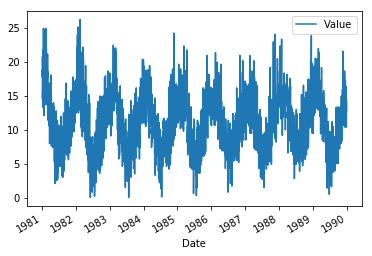

In [3]:
# Get raw dataset with new arguments
# Use Date column as x-axis
plt_raw_df = pd.read_csv('data/raw.csv', parse_dates=['Date'], index_col=['Date'], engine='python')
# Plot
plt_raw_df.plot()
plt.show()

In [4]:
# Get train dataset (raw dataset with features and labels)
train_df = pd.read_csv('data/train.csv', engine='python')
# Get column names
train_df.columns.values
# raw_df['Value'] == train_df['Label']

array(['Date', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'Label'], dtype=object)

In [5]:
# Get Xtr, Xval, Ytr and Yval in ndarray
train_size = int(len(train_df.values) * 0.7 // 1)
print(train_size)
# From F1 to F6 as matrix 6X1
Xtr = train_df.iloc[:train_size, 1:-1].values.reshape(-1, 6, 1).astype("float")
Xval = train_df.iloc[train_size:, 1:-1].values.reshape(-1, 6, 1).astype("float")
print(Xtr.shape)
print(Xval.shape)
# Label as matrix 6X1
Ytr = train_df.iloc[:train_size, -1].values.reshape(-1, 1).astype("float")
Yval = train_df.iloc[train_size:, -1].values.reshape(-1, 1).astype("float")
print(Ytr.shape)
print(Yval.shape)

2295
(2295, 6, 1)
(984, 6, 1)
(2295, 1)
(984, 1)


In [6]:
seq_length = 6
data_dim = 1 # dimension
num_classes = 1

with tf.device('/gpu:0'):
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, num_classes])

In [7]:
# Define a LSTM cell with TensorFlow
num_hidden = 512 # Hidden layer number of features

cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0,
                                    state_is_tuple=True, activation=tf.tanh)

# cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.8)

# Get cell output
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [8]:
# Use the last cell output
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=None)

In [9]:
# Define loss and optimizer
learning_rate = 0.001

# cost/loss
loss_op = tf.reduce_sum(tf.square(Y_pred - Y)) # Sum of squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss_op)

In [10]:
# RMSE for validation
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse_op = tf.sqrt(tf.reduce_mean(tf.square(predictions - targets))) # Root Mean Square Error

In [11]:
# Initialize the variables (i.e. assign their default value)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
def print_step(step, loss):
    print("Step {:04}: Minibatch Loss= {:.4f}".format(step, loss))

In [13]:
training_steps = 500

for step in range(1, training_steps + 1):
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: Xtr, Y: Ytr})
    
    if step % 100 == 0:
        loss = sess.run(loss_op, feed_dict={X: Xtr, Y: Ytr})
        print_step(step, loss)

Step 0100: Minibatch Loss= 16542.8164
Step 0200: Minibatch Loss= 14546.5078
Step 0300: Minibatch Loss= 14298.9023
Step 0400: Minibatch Loss= 14188.7129
Step 0500: Minibatch Loss= 14074.7959


In [14]:
# Validation
validationPredict = sess.run(Y_pred, feed_dict={X: Xval})
rmse = sess.run(rmse_op, feed_dict={targets: Yval, predictions: validationPredict})
print('RMSE: {:.4f}'.format(rmse))

RMSE: 2.3436


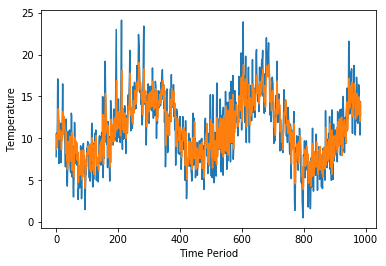

In [15]:
plt.plot(Yval)
plt.plot(validationPredict)
plt.xlabel("Time Period")
plt.ylabel("Temperature")
plt.show()

In [16]:
# Test
# Get train dataset (raw dataset with features and labels)
test_df = pd.read_csv('data/test.csv', engine='python')
# Get column names
test_df.columns.values

array(['Date', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6'], dtype=object)

In [17]:
# Get Xte in ndarrays
# Y for testing is not given
# From F1 to F6 as matrix 6X1
Xte = test_df.iloc[:, 1:].values.reshape(-1, 6, 1).astype("float")
print(Xte.shape)

(52, 6, 1)


In [18]:
testPredict = sess.run(Y_pred, feed_dict={X: Xte})

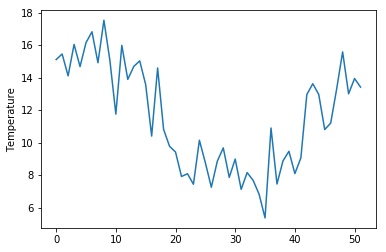

In [19]:
plt.plot(testPredict) # Prediction
plt.ylabel("Temperature")
plt.show()

In [20]:
predictions = testPredict.flatten()

In [21]:
def write_result(predictions):
    # You don't need to modify this function.
    with open('result.csv', 'w') as f:
        f.write('Value\n')
        for l in predictions:
            f.write('{}\n'.format(l))

In [22]:
write_result(predictions)